# Line ratios in the mid-infrared

The idea is to look at the ionization-sensitive ratios and compare them with the optical

In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve, convolve_fft
from matplotlib import pyplot as plt
from reproject import reproject_interp
from dataclasses import dataclass
from typing import Union

import seaborn as sns
import numpy as np

from pathlib import Path


In [2]:
datapath = Path.cwd().parent.parent / "data-jesus"

## Get all maps on a common grid

Read in the IRS line maps theat Jesús made for us

In [3]:
linedict = {
    #    "Ar III": "SL1_map_9.0_ArIII",
    "S IV": "SL1_map_10.5_SIV",
    "S III": "LL2_map_18.7_SIII",
    "Ne II": "SL1_map_12.8_NeII",
    "Ne III": "LL2_map_15.5_NeIII",
    "cont14": "SL1_map_cont_13-14",
    "cont18": "LL2_map_cont_16-18",
    "cont21": "LL2_map_cont_20-21",
    "cont09": "SL1_map_cont_8.5-10",
    "S IIIb": "LL1_map_33.4_SIII",
    "Si II": "LL1_map_34.8_SiII",
    "cont27": "LL1_map_cont_25-30",
    "PAH": "SL1_map_11.3_PAH",
}

I have dropped [Ar III] because it is too noisy

In [4]:
hdus = {
    label: fits.open(datapath / f"ngc346_{string}.fits")[0]
    for label, string in linedict.items()
}

Remove unwanted SIP values from the headers, since otherwise `astropy.wcs` will get upset.

In [5]:
for hdu in hdus.values():
    del hdu.header["PV*"]
    del hdu.header["A_*"]
    del hdu.header["B_*"]

We need to reproject the maps to a common pixel grid before we can to take ratios. We want an orthogonal grid in RA, DEC to make life easier, which we will center on W3

In [6]:
c0 = SkyCoord.from_name("Cl* NGC 346 W 3")

And choose 1 arcsec pixels and 6 arcmin field of view

In [7]:
NY, NX = 6 * 60, 6 * 60
w0 = WCS(naxis=2)
w0.wcs.crpix = [NX / 2, NY / 2]
w0.wcs.crval = [c0.ra.deg, c0.dec.deg]
w0.wcs.cdelt = np.array([-1.0, 1.0]) / 3600.0
w0.wcs.ctype = ["RA---TAN", "DEC--TAN"]

In [8]:
maps = {
    label: reproject_interp(
        hdu,
        w0,
        (NY, NX),
        order="nearest-neighbor",
        return_footprint=False,
    )
    for label, hdu in hdus.items()
}

***TODO*** Smoothe all the shorter wave maps to the worst resolution (currently S III)

## Plot the images


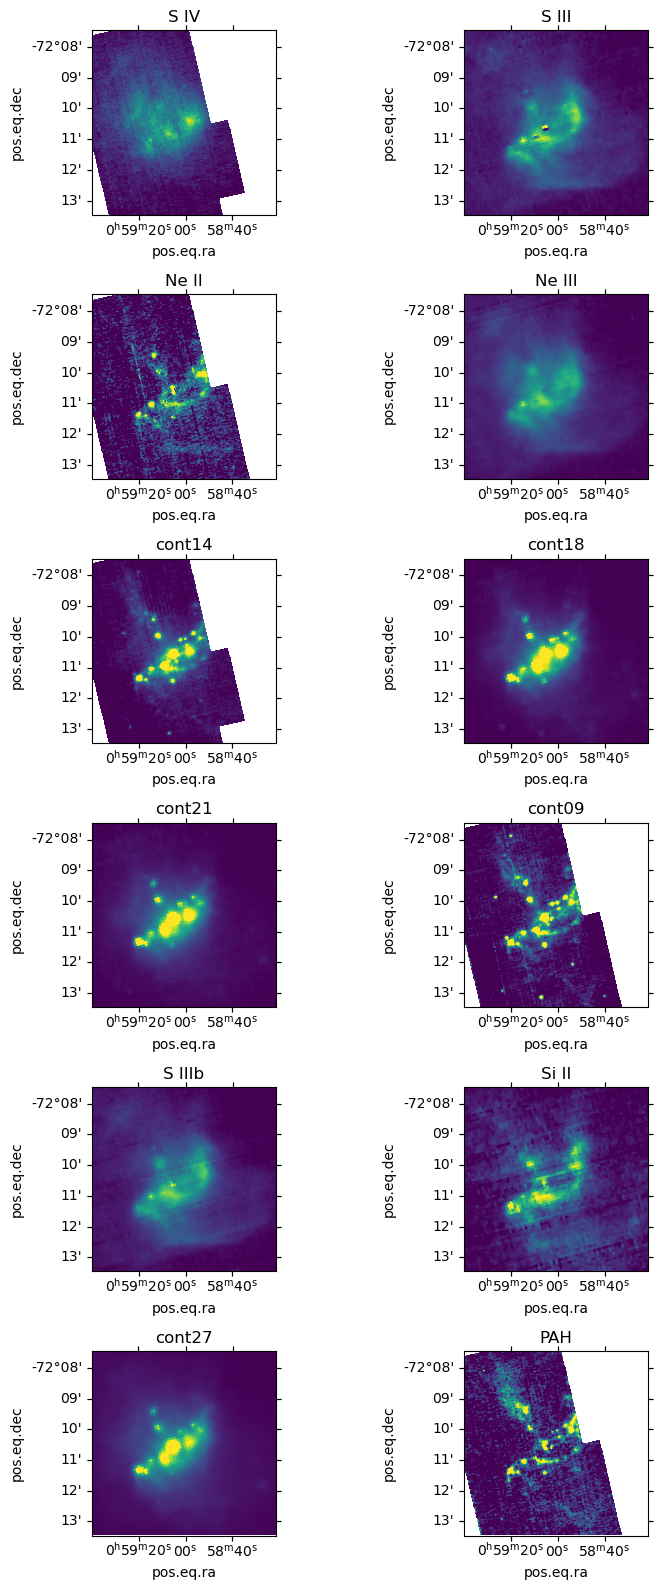

In [9]:
ncol = 2
fig, axes = plt.subplots(
    len(linedict) // 2,
    ncol,
    figsize=(8, 16),
    subplot_kw=dict(projection=w0),
)
bscale = {}
for ax, line in zip(axes.flat, linedict.keys()):
    mask = np.isfinite(maps[line])
    bscale[line] = 2 * np.percentile(maps[line][mask], 95)
    ax.imshow(maps[line], vmin=0, vmax=bscale[line])
    ax.set_title(line)
fig.tight_layout()

## Make ratios of the images

Define a `Ratio` class, which allows for the sum of one or more bands in both the numerator and denominator.  We only use this for [S III], which has two lines.

We use the same class for calculating equivalent widths as `LINE / CONTINUUM`. This requires "`EW`" to be in the `label` and an extra parameter `dwave` that is the sum of the widths of the continumm bands.

We calculate two different typical valuses for the ratio, the `median` (self-explanatory) and the `scale`, which is the ratio of the 95th centiles of the numerator and denominator. The `scale` turns out to be a better typical value.

In [10]:
@dataclass
class Ratio:
    label: str
    num: Union[str, list[str]]
    den: Union[str, list[str]]
    dwave: float = 1.0
    blur: float = 0.0

    def __post_init__(self):
        if isinstance(self.num, str):
            self.num = [self.num]
        if isinstance(self.den, str):
            self.den = [self.den]
        numerator = np.nansum(np.stack([maps[lab] for lab in self.num]), axis=0)
        denominator = np.nansum(np.stack([maps[lab] for lab in self.den]), axis=0)
        if self.blur > 0.0:
            kernel = Gaussian2DKernel(x_stddev=self.blur)
            numerator = convolve_fft(numerator, kernel, preserve_nan=True)
            denominator = convolve_fft(denominator, kernel, preserve_nan=True)
        self.ratio = np.where(
            (denominator > 0.0) & np.isfinite(denominator * numerator),
            numerator / denominator,
            np.nan
        )
        if "EW" in self.label:
            self.ratio *= self.dwave
        self.mask = np.isfinite(self.ratio)
        self.ratio[~self.mask] = np.nan
        self.scale = np.percentile(numerator[self.mask], 95) / np.percentile(
            denominator[self.mask], 95
        )
        self.median = np.nanmedian(self.ratio[self.mask])
        if "EW" in self.label:
            # The median is a better typical value for EWs
            self.scale = self.median

Take all the ratios that might occur to us.

In [11]:
ratios = [
    Ratio("s43", "S IV", ["S III", "S IIIb"]),
    Ratio("s33", "S III", "S IIIb"),
    Ratio("ne32", "Ne III", "Ne II"),
    Ratio("ne3s3", "Ne III", ["S III", "S IIIb"]),
    Ratio("color14-09", "cont14", "cont09"),
    Ratio("color21-18", "cont21", "cont18"),
    Ratio("color27-21", "cont27", "cont21"),
    Ratio("color27-14", "cont27", "cont14"),
    Ratio("EWs4", "S IV", ["cont09", "cont14"], dwave=2.5),
    Ratio("EWs3", "S III", "cont27", dwave=5.0),
    Ratio("EWs3b", "S IIIb", "cont27", dwave=5.0),
    Ratio("c14-s4", "cont14", "S IV"),
    Ratio("s4ne2", "S IV", "Ne II"),
    Ratio("c14-s3", "cont14", ["S III", "S IIIb"]),
    Ratio("si2-s3", "Si II", "S III"),
    Ratio("si2-ne2", "Si II", "Ne II"),
    Ratio("pah-ne2", "PAH", "Ne II"),
    Ratio("pah-c09", "PAH", "cont09"),
]

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide
  numerator / denominator,
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide
  numerator / denominator,


### Plot the ratios

We use a logarithmic scale of two dex, centered on the `scale` value

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/37824920.py:11: RuntimeWarning: divide by zero encountered in log10
  np.log10(rat.ratio),
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/37824920.py:11: RuntimeWarning: invalid value encountered in log10
  np.log10(rat.ratio),


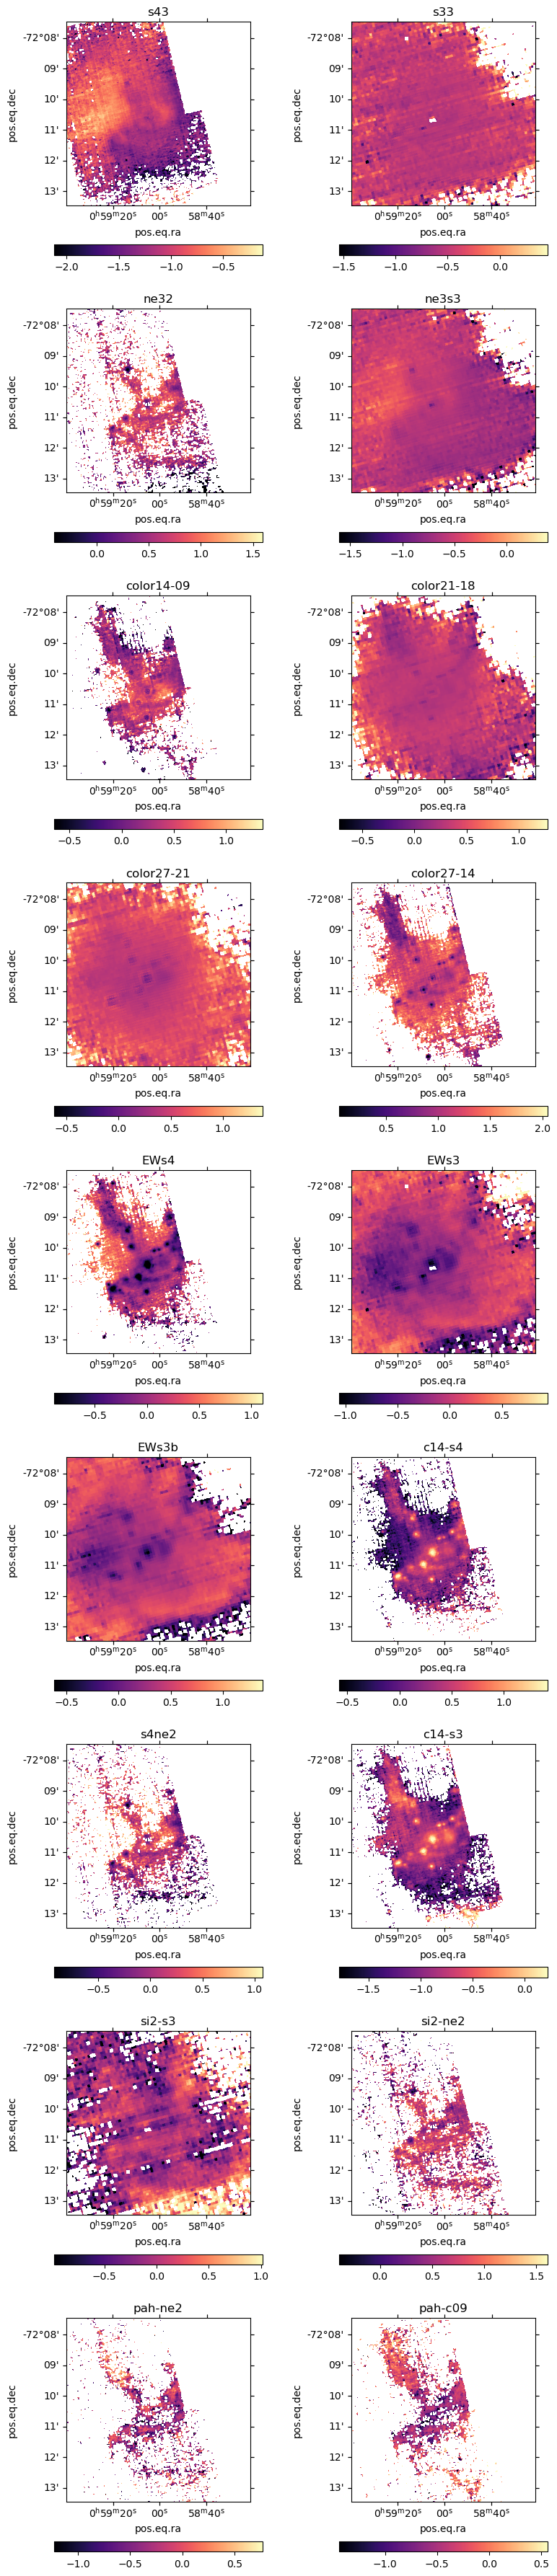

In [12]:
NCOL = 2
NROW = (len(ratios) + NCOL - 1) // NCOL
fig, axes = plt.subplots(
    NROW,
    NCOL,
    figsize=(4 * NCOL, 4 * NROW),
    subplot_kw=dict(projection=w0),
)
for ax, rat in zip(axes.flat, ratios):
    im = ax.imshow(
        np.log10(rat.ratio),
        vmin=np.log10(rat.scale) - 1.0,
        vmax=np.log10(rat.scale) + 1.0,
        cmap="magma",
    )
    ax.set_title(rat.label)
    fig.colorbar(im, ax=ax, orientation="horizontal")
fig.tight_layout()

### Blurred versions of the ratios


In [13]:
bratios = [Ratio(r.label, r.num, r.den, r.dwave, blur=2.5) for r in ratios]

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide
  numerator / denominator,
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide
  numerator / denominator,


/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/897185632.py:11: RuntimeWarning: divide by zero encountered in log10
  np.log10(rat.ratio),
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/897185632.py:11: RuntimeWarning: invalid value encountered in log10
  np.log10(rat.ratio),


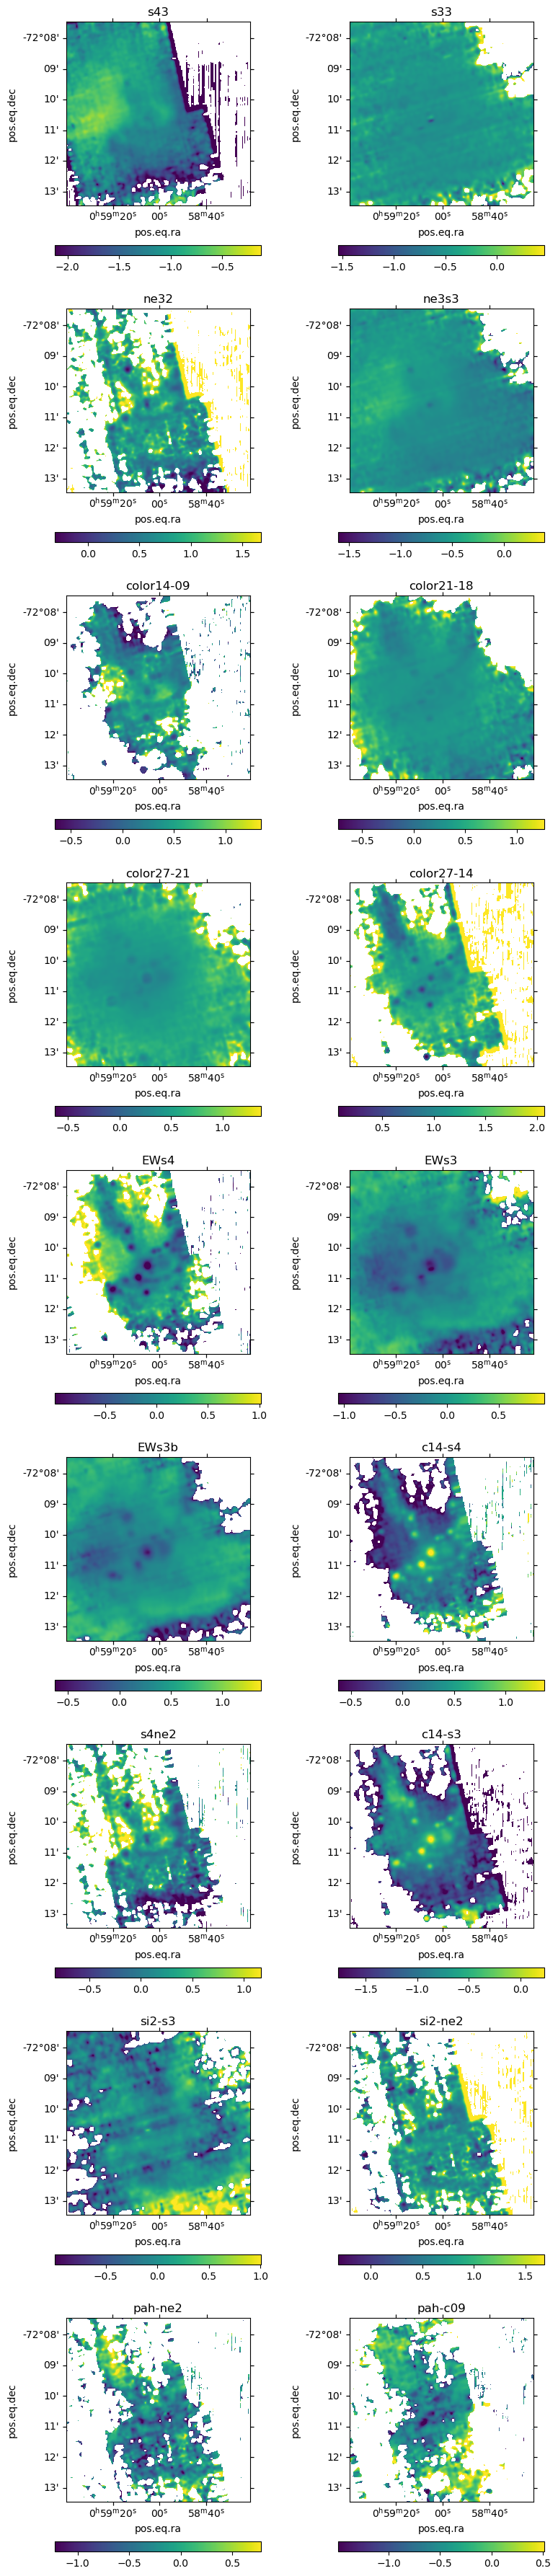

In [14]:
NCOL = 2
NROW = (len(bratios) + NCOL - 1) // NCOL
fig, axes = plt.subplots(
    NROW,
    NCOL,
    figsize=(4 * NCOL, 4 * NROW),
    subplot_kw=dict(projection=w0),
)
for ax, rat in zip(axes.flat, bratios):
    im = ax.imshow(
        np.log10(rat.ratio),
        vmin=np.log10(rat.scale) - 1.0,
        vmax=np.log10(rat.scale) + 1.0,
        cmap="viridis",
    )
    ax.set_title(rat.label)
    fig.colorbar(im, ax=ax, orientation="horizontal")
fig.tight_layout()

## Color-color diagrams

### Define a function to make the color-color plots

Creates a 2d histogram from a pair of ratio images

In [15]:
def color_color_plot(rat1, rat2, weights, ax=None, nbins=100, wx=1.0, wy=1.0, aspect="equal"):
    mask = rat1.mask & rat2.mask & np.isfinite(weights) & (weights > 0.0)
    x = np.log10(rat1.ratio[mask])
    xmin = np.log10(rat1.scale) - wx
    xmax = np.log10(rat1.scale) + wx
    y = np.log10(rat2.ratio[mask])
    ymin = np.log10(rat2.scale) - wy
    ymax = np.log10(rat2.scale) + wy

    H, xedges, yedges = np.histogram2d(
        x,
        y,
        bins=nbins,
        range=[[xmin, xmax], [ymin, ymax]],
        density=True,
        weights=weights[mask],
    )
    if ax is None:
        ax = plt.gca()
    im = ax.imshow(
        H.T,
        extent=[xmin, xmax, ymin, ymax],
        origin="lower",
        aspect=aspect,
        cmap="inferno_r",
        interpolation="none",
    )
    ax.set(
        xlabel=f"log10( {rat1.label} )",
        ylabel=f"log10( {rat2.label} )",
    )
    return im

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide
  numerator / denominator,
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide
  numerator / denominator,
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])


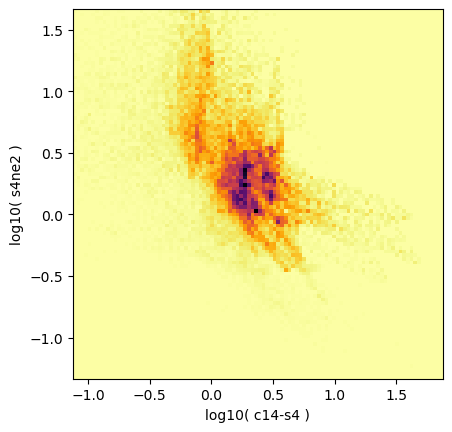

In [16]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("c14-s4", "cont14", "S IV", blur=2.5),
    Ratio("s4ne2", "S IV", "Ne II", blur=2.5),
    maps["S IV"],
    ax=ax,
    nbins=100,
    wx=1.5,
    wy=1.5,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide
  numerator / denominator,
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:6: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(rat2.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


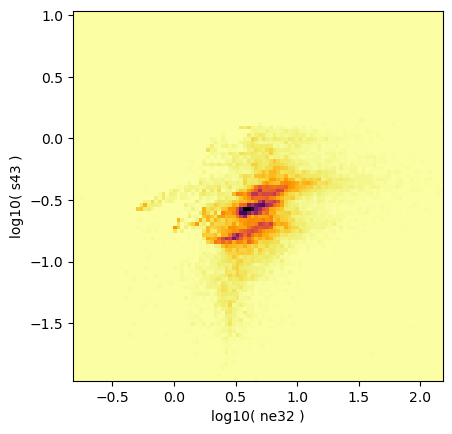

In [17]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("ne32", "Ne III", "Ne II", blur=2.5),
#    Ratio("s43", "S IV", ["S III", "S IIIb"], blur=2.5),
    Ratio("s43", "S IV", "S III", blur=2.5),
    maps["Ne II"],
    ax=ax,
    nbins=100,
    wx=1.5,
    wy=1.5,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:6: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(rat2.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


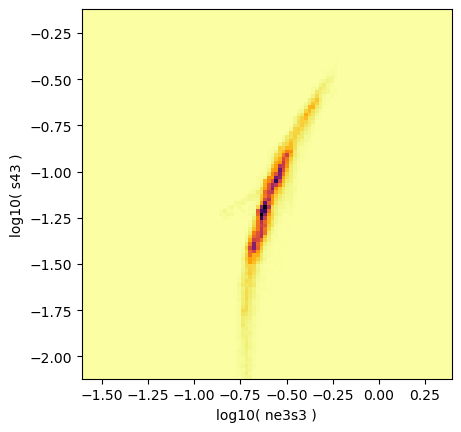

In [18]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("ne3s3", "Ne III", ["S III", "S IIIb"], blur=2.5),
    Ratio("s43", "S IV", ["S III", "S IIIb"], blur=2.5),
    maps["S III"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


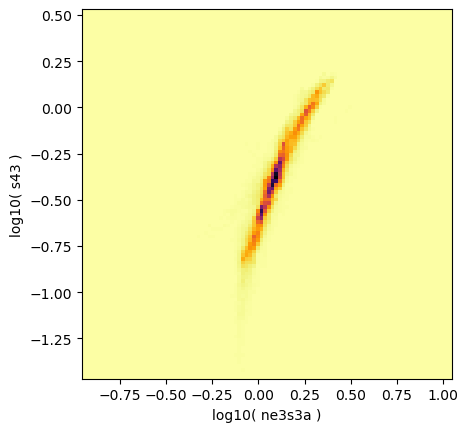

In [19]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("ne3s3a", "Ne III", "S III", blur=2.5),
    Ratio("s43", "S IV", "S III", blur=2.5),
    maps["S IV"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


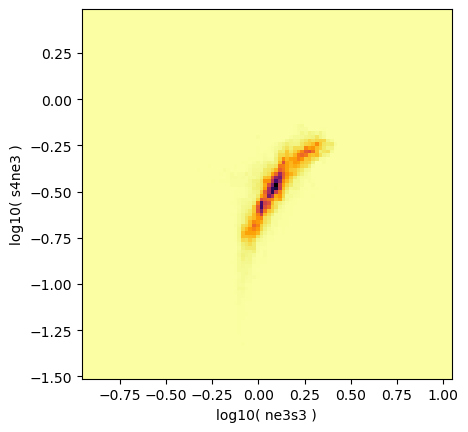

In [20]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("ne3s3", "Ne III", "S III", blur=2.5),
    Ratio("s4ne3", "S IV", "Ne III", blur=2.5),
    maps["S IV"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


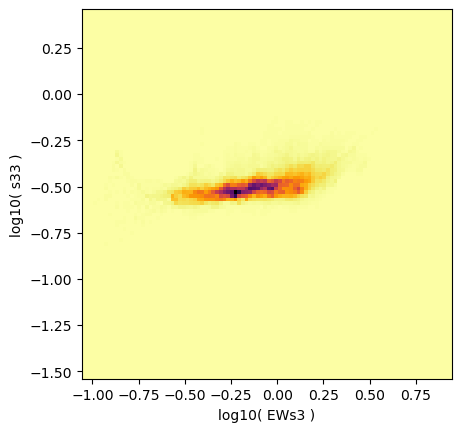

In [21]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("EWs3", "S III", "cont27", dwave=5.0, blur=2.5),
    Ratio("s33", "S III", "S IIIb", blur=2.5),
    maps["S III"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide
  numerator / denominator,
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide
  numerator / denominator,


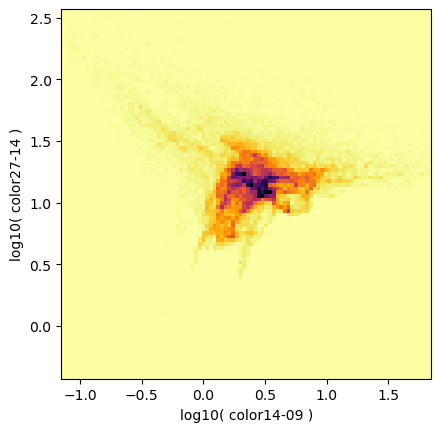

In [22]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("color14-09", "cont14", "cont09", blur=2.5),
    Ratio("color27-14", "cont27", "cont14", blur=2.5),
    maps["S IV"],
    ax=ax,
    nbins=100,
    wx=1.5,
    wy=1.5,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide
  numerator / denominator,
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide
  numerator / denominator,
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])


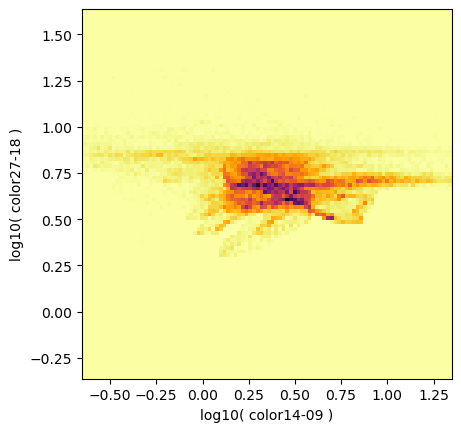

In [23]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("color14-09", "cont14", "cont09", blur=2.5),
    Ratio("color27-18", "cont27", "cont18", blur=2.5),
    maps["S IV"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide
  numerator / denominator,
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide
  numerator / denominator,
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])


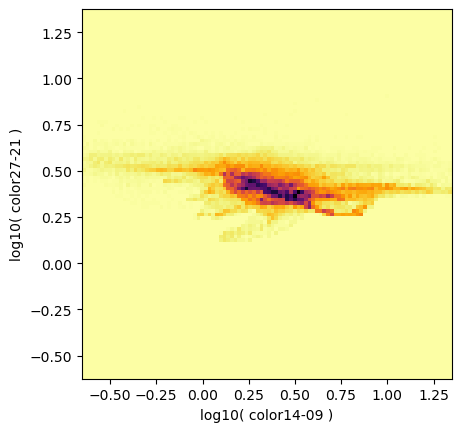

In [24]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("color14-09", "cont14", "cont09", blur=2.5),
    Ratio("color27-21", "cont27", "cont21", blur=2.5),
    maps["S IV"],
    ax=ax,
    nbins=100,
#    wy=0.5,
#    aspect="auto",
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


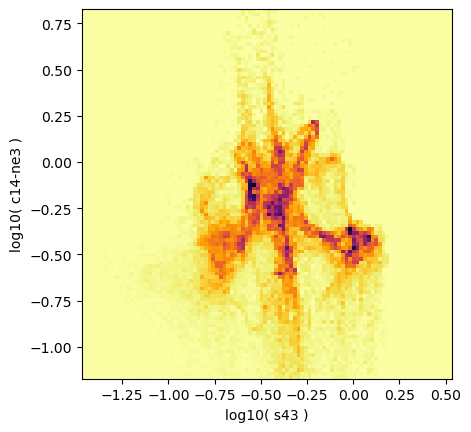

In [25]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("s43", "S IV", "S III", blur=2.5),
    Ratio("c14-ne3", "cont14", "Ne III", blur=2.5),
#   Ratio("c14-s4", "cont14", "S IV"),
    maps["S IV"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide
  numerator / denominator,
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide
  numerator / denominator,
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


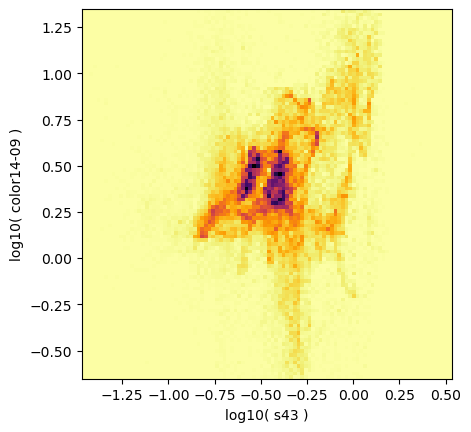

In [26]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("s43", "S IV", "S III", blur=2.5),
    Ratio("color14-09", "cont14", "cont09", blur=2.5),
#    Ratio("color27-14", "cont27", "cont14"),
    maps["S IV"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide
  numerator / denominator,
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide
  numerator / denominator,
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


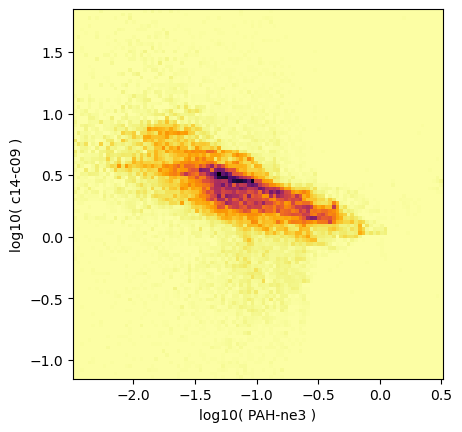

In [27]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("PAH-ne3", "PAH", "Ne III", blur=2.5),
    Ratio("c14-c09", "cont14", "cont09", blur=2.5),
    maps["S IV"],
    ax=ax,
    nbins=100,
    wx=1.5,
    wy=1.5,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide
  numerator / denominator,
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:3: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


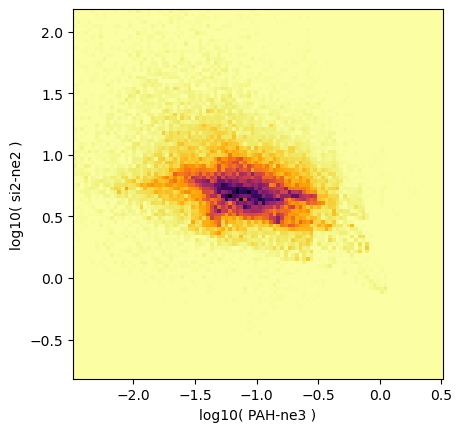

In [28]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("PAH-ne3", "PAH", "Ne III", blur=2.5),
    Ratio("si2-ne2", "Si II", "Ne II", blur=2.5),
    maps["S III"],
    ax=ax,
    nbins=100,
    wx=1.5,
    wy=1.5,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide
  numerator / denominator,
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide
  numerator / denominator,
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


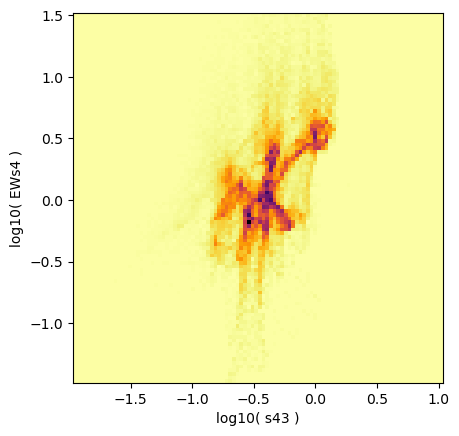

In [29]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("s43", "S IV", "S III", blur=2.5),
    Ratio("EWs4", "S IV", ["cont09", "cont14"], dwave=2.5, blur=2.5),
#    Ratio("EWs4", "S IV", ["cont14"], dwave=1.0),
    maps["S IV"],
#    maps["Ne III"],
    ax=ax,
    nbins=100,
    wx=1.5,
    wy=1.5,
)

### Use just the 18 micron S III line

This is to make for easier comparison with the Cloudy results. 

*Note that this section is a bit pointless now since I have gone back and redone many of the previous ratios with just the shorter line*



/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


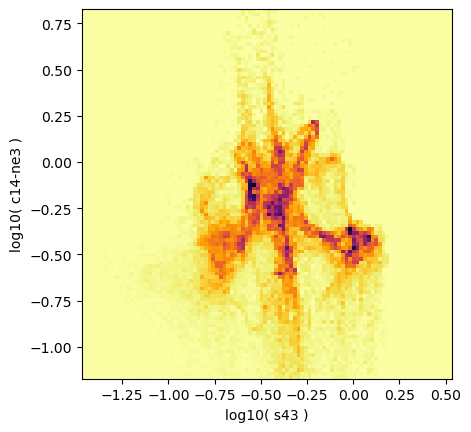

In [30]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("s43", "S IV", "S III", blur=2.5),
    Ratio("c14-ne3", "cont14", "Ne III", blur=2.5),
    maps["S IV"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:3: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


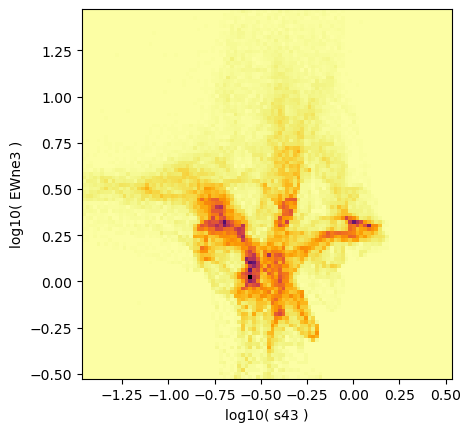

In [36]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("s43", "S IV", "S III", blur=2.5),
    Ratio("EWne3", "Ne III", ["cont14", "cont18"], dwave=3.0, blur=2.5),
    maps["Ne III"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide
  numerator / denominator,
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])


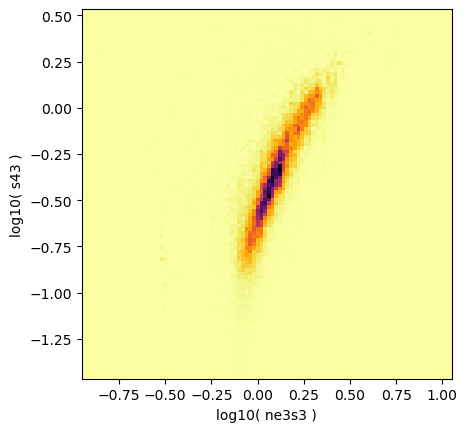

In [31]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("ne3s3", "Ne III", "S III"),
    Ratio("s43", "S IV", "S III"),
    maps["S IV"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide
  numerator / denominator,
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])


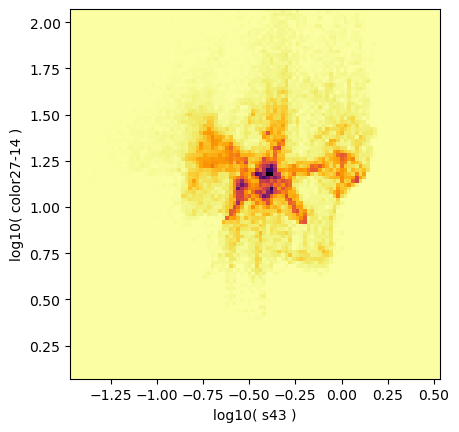

In [38]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("s43", "S IV", "S III", blur=2.5),
#    Ratio("color14-09", "cont14", "cont09"),
    Ratio("color27-14", "cont27", "cont14", blur=2.5),
    maps["S IV"],
    ax=ax,
    nbins=100,
)

So the above is a good diagnostic diagram for the bow shock. The bow shock region is `s43 > -0.3` and `color27-14 < 1.05`.

This distinguishes it from the SNR, which has redder continuum and higher s43. 

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide
  numerator / denominator,
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide
  numerator / denominator,
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


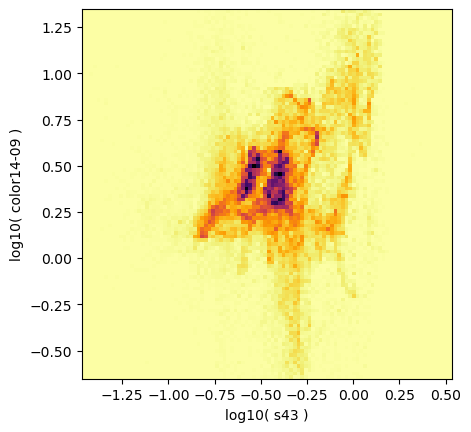

In [39]:
fig, ax = plt.subplots()
color_color_plot(
    Ratio("s43", "S IV", "S III", blur=2.5),
    Ratio("color14-09", "cont14", "cont09", blur=2.5),
#    Ratio("color27-14", "cont27", "cont14"),
    maps["S IV"],
    ax=ax,
    nbins=100,
)

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: divide by zero encountered in true_divide
  numerator / denominator,
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/3757191001.py:22: RuntimeWarning: invalid value encountered in true_divide
  numerator / denominator,
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/1292939596.py:24: RuntimeWarning: divide by zero encountered in log10
  np.log10(rat.ratio),
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/1292939596.py:24: RuntimeWarning: invalid value encountered in log10
  np.log10(rat.ratio),
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/1292939596.py:30: RuntimeWarning: divide by zero encountered in log10
  ax.contour(np.log10(rat.ratio), levels=leveldict[rat.label], colors="g", linestyles="solid")
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/1292939596.py:30: RuntimeWarning: invalid value encount

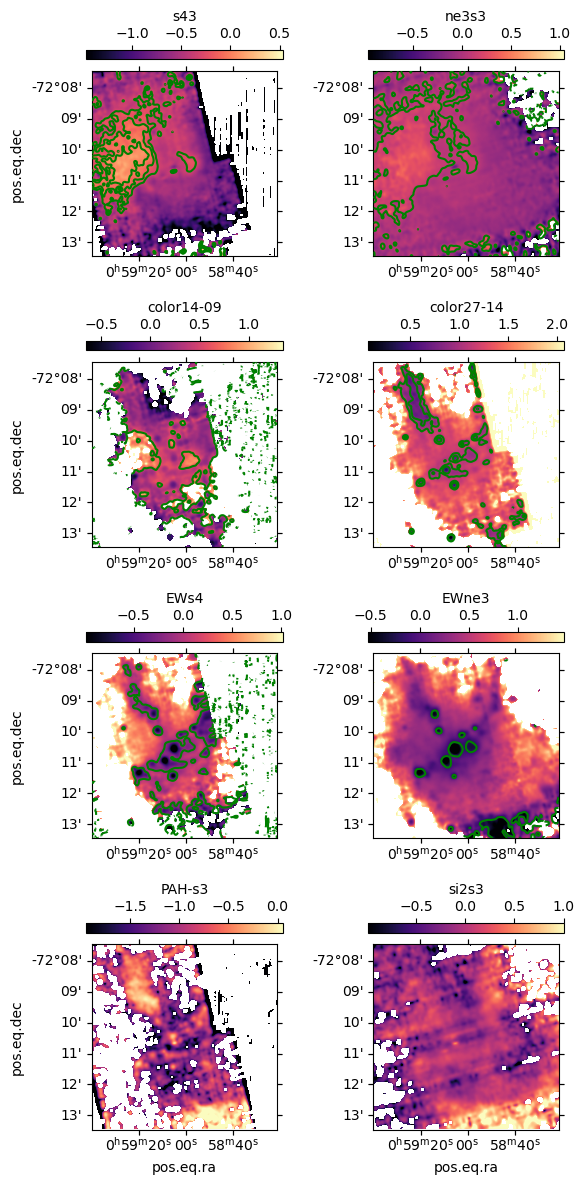

In [76]:
ratios = {
    "s43": Ratio("s43", "S IV", "S III", blur=2.5),
    "ne3s3": Ratio("ne3s3", "Ne III", "S III", blur=2.5),
    "color14-09": Ratio("color14-09", "cont14", "cont09", blur=2.5),
    "color27-14": Ratio("color27-14", "cont27", "cont14", blur=2.5),
    "EWs4": Ratio("EWs4", "S IV", ["cont09", "cont14"], dwave=2.5, blur=2.5),
    "EWne3": Ratio("EWne3", "Ne III", ["cont14", "cont18"], dwave=3.0, blur=2.5),
    "PAH-s3": Ratio("PAH-s3", "PAH", "S III", blur=2.5),
    "si2s3": Ratio("si2s3", "Si II", "S III", blur=2.5),
}
leveldict = {"s43": [-0.3, -0.15, 0.0], "ne3s3": [0.1], "color27-14": [0.8, 1.05], "color14-09": [0.6], "EWs4": [-0.15], "EWne3": [-0.2]}
NCOL = 2
NROW = (len(ratios) + NCOL - 1) // NCOL
fig, axes = plt.subplots(
    NROW,
    NCOL,
    figsize=(3 * NCOL, 3 * NROW),
    subplot_kw=dict(projection=w0),
    sharex=True,
    sharey=True,
)
for ax, rat in zip(axes.flat, ratios.values()):
    im = ax.imshow(
        np.log10(rat.ratio),
        vmin=np.log10(rat.scale) - 1.0,
        vmax=np.log10(rat.scale) + 1.0,
        cmap="magma",
    )
    if rat.label in leveldict:
        ax.contour(np.log10(rat.ratio), levels=leveldict[rat.label], colors="g", linestyles="solid")
    fig.colorbar(im, ax=ax, location="top", label=rat.label)
for ax in axes[:, 1:].flat:
    ax.coords[1].set_auto_axislabel(False)
for ax in axes[:-1, :].flat:
    ax.coords[0].set_auto_axislabel(False)
    
fig.tight_layout()

### Put all the best ratio-ratio plots together

/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(rat1.ratio[mask])
/var/folders/sv/41w0vxds13d20rvl07t_1x2w0000gn/T/ipykernel_40679/413289213.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rat2.ratio[mask])


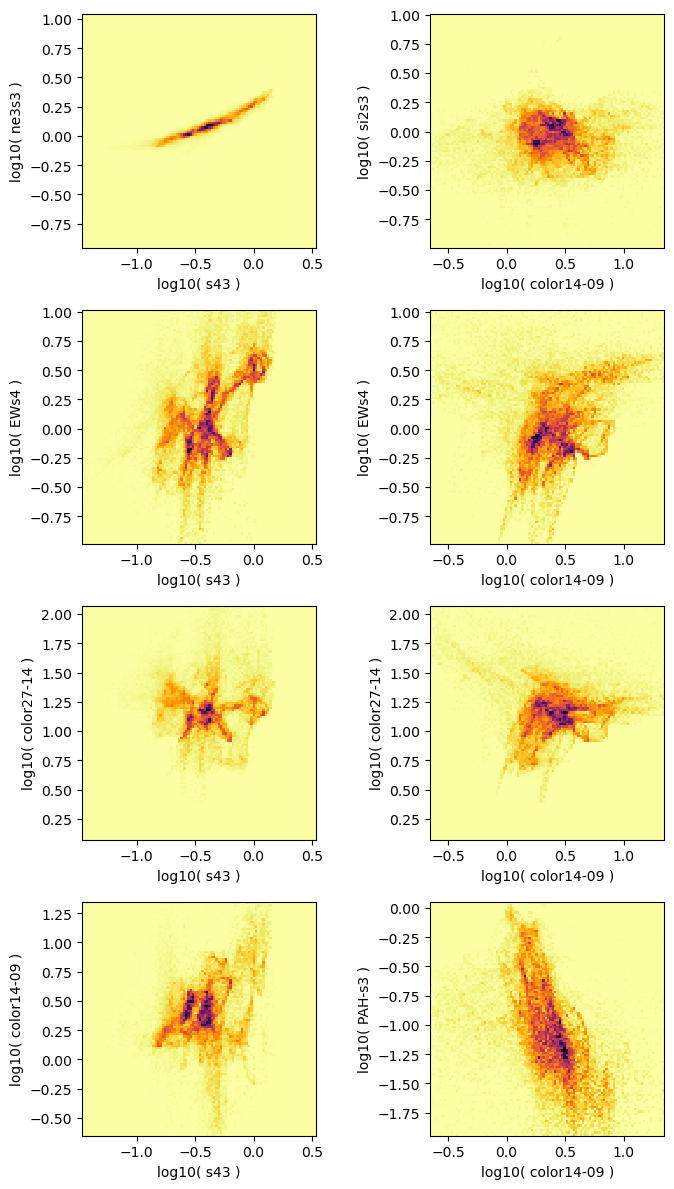

In [73]:
NCOL = 2
NROW = 4
fig, axes = plt.subplots(
    NROW,
    NCOL,
    figsize=(3.5 * NCOL, 3 * NROW),
#    sharex="col",
#    sharey="row",
)
color_color_plot(ratios["s43"], ratios["ne3s3"], maps["S IV"], ax=axes[0, 0])
color_color_plot(ratios["s43"], ratios["EWs4"], maps["S IV"], ax=axes[1, 0])
color_color_plot(ratios["s43"], ratios["color27-14"], maps["S IV"], ax=axes[2, 0])
color_color_plot(ratios["s43"], ratios["color14-09"], maps["S IV"], ax=axes[3, 0])

color_color_plot(ratios["color14-09"], ratios["si2s3"], maps["S IV"], ax=axes[0, 1])
color_color_plot(ratios["color14-09"], ratios["EWs4"], maps["S IV"], ax=axes[1, 1])
color_color_plot(ratios["color14-09"], ratios["color27-14"], maps["S IV"], ax=axes[2, 1])
color_color_plot(ratios["color14-09"], ratios["PAH-s3"], maps["S IV"], ax=axes[3, 1])
fig.tight_layout(w_pad=3)

In [74]:
fig.savefig("midinfrared-ratio-ratio-plots.pdf", bbox_inches="tight")